###Problems encounter and solved

1. initially there is very high loss that means the nn is confidently   very wrong so we corrected that by multiplying 0 to b2 and a small number(0.001) to w2


2. Value of h
    tanh is very very active the preactivation takes a broad range, maximum values are squashed into eithr -1 or 1  which is not good for our NN
    if this happens maximum no of neurons will never get activated.
    to solve this we multiply b1 and w1 with small numbers like(0.01)

3. Batch normalization
    used to train large neural networks
    if you want the hpreact to be roughly gaussian why not take the hidden states and normalize them to be gaussian 
    we will add bngain and bnbias to the hpreact to normalise them


    When you are using batch noralization layer then biases have no role in the calculations so you do not use the bais to prevent unnecessary calculations because it doesn't have any significance

In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words=open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)


32033

In [4]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [51]:
#Build the dataset
block_size=3
def build_dataset(words):
    X,Y=[],[]
    for w in words:

        context = [0]*block_size
        for ch in w +'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
#MLP revisited
n_embd=10
n_hidden=200
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embd),generator=g)
W1=torch.randn((n_embd*block_size,n_hidden),generator=g)*(5/3)/((n_embd *block_size)**0.5)
# b1=torch.randn((n_hidden),generator=g)*0.01
W2=torch.randn((n_hidden,vocab_size),generator=g)*0.01
b2=torch.randn((vocab_size),generator=g)*0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running=torch.ones((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))
parameters=[C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True
    

11897


In [104]:
hpreact.mean(0,keepdims=True).shape,hpreact.std(0,keepdims=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [ ]:
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):
    #Minibatch generator
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]

    #Forward pass
    emb=C[Xb]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@W1 #+b1
    bnmeani=hpreact.mean(0,keepdims=True)
    bnstdi=hpreact.std(0,keepdims=True)
    hpreact=bngain * (hpreact-bnmeani) / (bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running=0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    h=torch.tanh(hpreact)
    logits=h@W2+b2
    loss= F.cross_entropy(logits,Ytr[ix])

    #Backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #Update
    lr = 0.01 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break



      0/ 200000: 3.3014


tensor(0.0113) tensor(1.0017)
tensor(0.0146) tensor(3.2411)


(array([6.62695643e-06, 0.00000000e+00, 6.62695643e-06, 0.00000000e+00,
        1.32539129e-05, 1.32539129e-05, 3.31347822e-05, 3.31347822e-05,
        7.95234772e-05, 1.06031303e-04, 4.24125212e-04, 5.63291297e-04,
        9.87416508e-04, 1.62360433e-03, 2.77006779e-03, 4.73827385e-03,
        7.02457382e-03, 1.11134059e-02, 1.74090145e-02, 2.62692553e-02,
        3.67464734e-02, 5.18956958e-02, 7.02788730e-02, 9.00735918e-02,
        1.08801371e-01, 1.23446944e-01, 1.32658414e-01, 1.29391324e-01,
        1.19550294e-01, 1.01823186e-01, 8.23266797e-02, 6.41754461e-02,
        4.62362750e-02, 3.26907761e-02, 2.20545110e-02, 1.47781128e-02,
        9.53619030e-03, 5.92449905e-03, 3.89665038e-03, 2.33931562e-03,
        1.49769215e-03, 7.68726946e-04, 5.23529558e-04, 3.90990429e-04,
        1.65673911e-04, 6.62695643e-05, 5.30156515e-05, 5.30156515e-05,
        1.32539129e-05, 1.98808693e-05]),
 array([-20.22126961, -19.46677544, -18.71228127, -17.95778709,
        -17.20329292, -16.4487

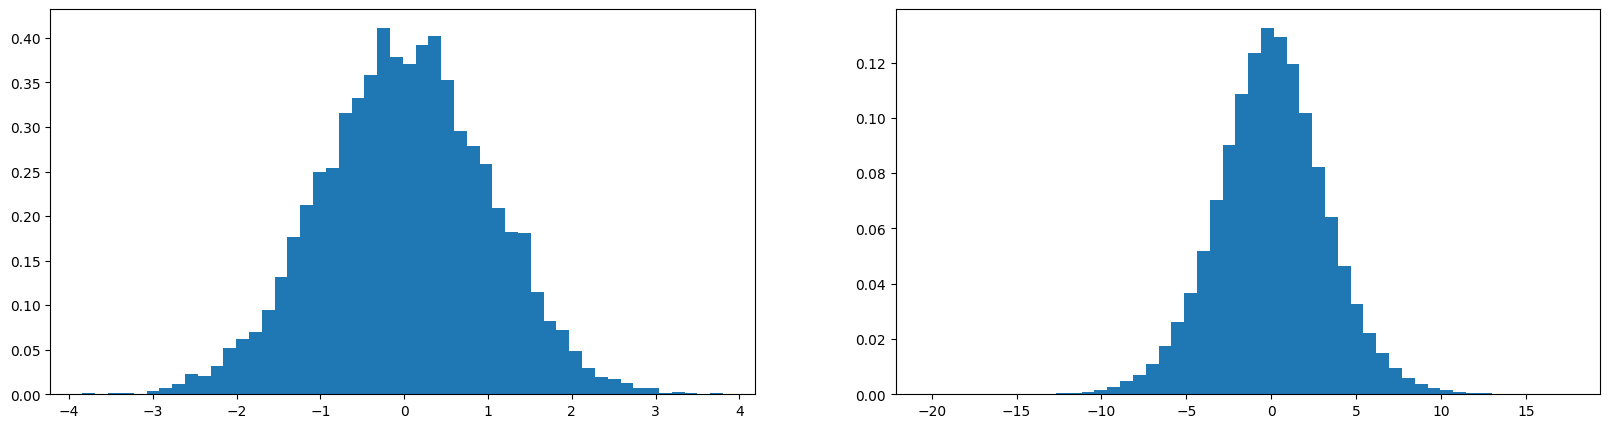

In [86]:
#How to get the values which we multiplied with weights and biases
x=torch.randn(1000,10)
w=torch.randn(10,200)
y= x @ w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True)

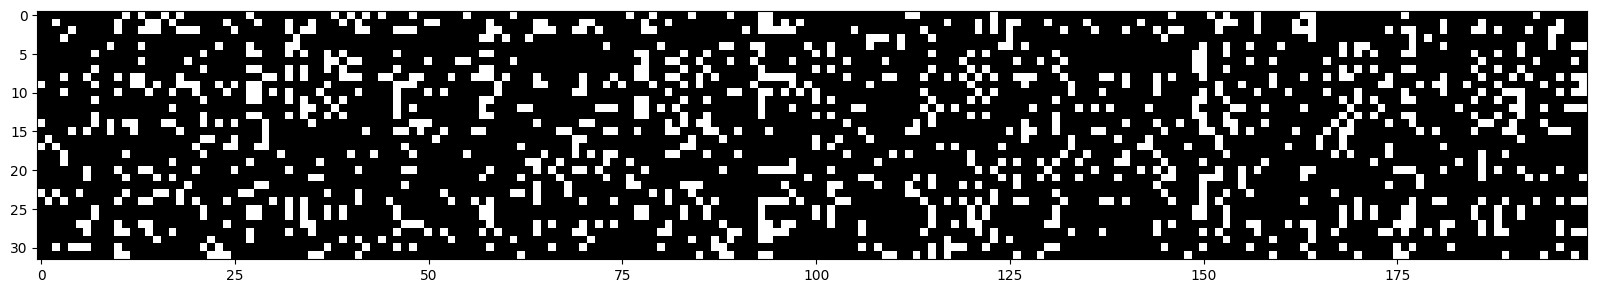

In [80]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

(array([1010.,  315.,  201.,  164.,  127.,  136.,  144.,   91.,   86.,
          90.,   77.,   58.,   88.,   60.,   57.,   45.,   58.,   47.,
          56.,   49.,   39.,   42.,   39.,   52.,   45.,   51.,   51.,
          46.,   43.,   35.,   35.,   40.,   57.,   71.,   53.,   68.,
          59.,   53.,   66.,   68.,  100.,   80.,  122.,  106.,  108.,
         122.,  181.,  189.,  302., 1118.]),
 array([-9.99999166e-01, -9.59999187e-01, -9.19999208e-01, -8.79999230e-01,
        -8.39999251e-01, -7.99999273e-01, -7.59999294e-01, -7.19999316e-01,
        -6.79999337e-01, -6.39999359e-01, -5.99999380e-01, -5.59999402e-01,
        -5.19999423e-01, -4.79999444e-01, -4.39999466e-01, -3.99999487e-01,
        -3.59999509e-01, -3.19999530e-01, -2.79999552e-01, -2.39999573e-01,
        -1.99999595e-01, -1.59999616e-01, -1.19999638e-01, -7.99996591e-02,
        -3.99996805e-02,  2.98023224e-07,  4.00002766e-02,  8.00002551e-02,
         1.20000234e-01,  1.60000212e-01,  2.00000191e-01,  2.400001

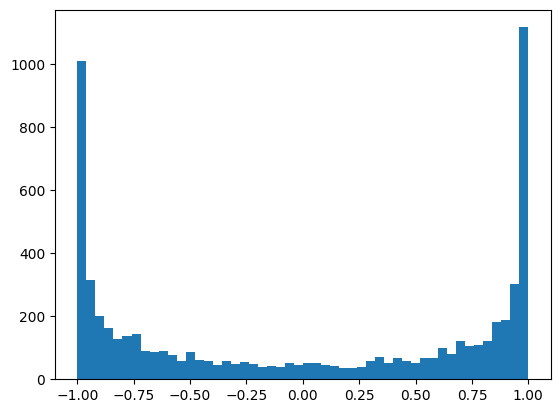

In [91]:
plt.hist(h.view(-1).tolist(),50)

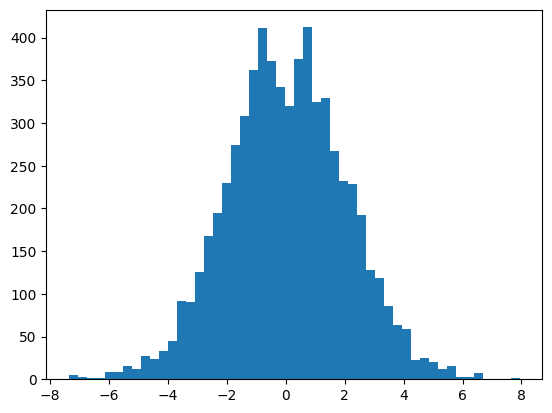

In [82]:
plt.hist(hpreact.view(-1).tolist(),50);

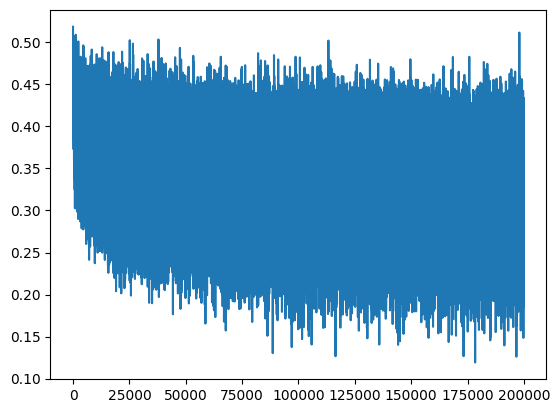

In [83]:
plt.plot(lossi)

In [ ]:
#calibrate the batch norm at the end of training

# with torch.no_grad():
#     #pass the training set through
#     emb = C[Xtr]
#     embcat=emb.view(emb.shape[0],-1)
#     hpreact=embcat@W1+b1
#     bnmean=hpreact.mean(0,keepdim=True)
#     bnstd=hpreact.std(0,keepdim=True)



### WE have skipped this step by using bnstd running and bnmean running the the above loop so  that we donot have to terate it all over once again 

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact= embcat@W1 + b1
    hpreact=bngain * (hpreact-bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('dev')



train 3.302076816558838
dev 3.3025074005126953


In [97]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cbrpzhxqtbfhqvkfkwmrpxqthtykhkcaqskejrzhnbnfqpwsyhc.
vgqhiunrzmuqptcmziivduxlhggphhbmgpoindqbqjtzsrlivwa.
vvdbquwqzthogdjaryxixfkqeupiusdbwed.
ecoiatgtlffhysflquhpqgmovdjhksyjrpmqqosozswjcojqmwyojsfrenqkpfsadlnuo.
zoebsrkoiyzhrynhg.
opklhynrxyh.
xqioloqbplbvbbdn.
ipyqmuitjpbvfpzpddgpycsislqwkkmconzauqnljydpk.
kvweskatikzamdtevl.
ky.
qdyctoorowooktbymouokfbfcw.
zoindzcs.
nu.
eoaignqqerosci.
icfzykbadyieluglconwzyzdjokhnlkjjqsxmuadltjhvtoyaplwuw.
xisxwrmfv.
qphtzbiuzzsrvgmknbfyntiysfgdgkgmmj.
pqgcrvdhpvdafpsdvkhzkxkidtvoscvupgawjmjqjwgvhflwkewtxarclxdytlvhgqllyuil.
hhza.
gfcmkjpoubjbiygh.


In [106]:
#_______________________SUMMARY___________________

In [ ]:
s